In [1]:
import sys
import os
# define directory to packages and append to $PATH

par_dir = os.path.abspath(os.path.pardir)
print(par_dir)
pkg_dir = os.path.join(par_dir,"pylib")
print(pkg_dir)
sys.path.append(pkg_dir)

#import additional python packages
import numpy as np
import matplotlib.pyplot as plt
# import additional simulation packages
import hpsim as hps
# use next line to select either GPU 0 or 2 on aothpsim
GPU = 0
hps.set_gpu(GPU)
from hpsim import sqldb as pydb

/home/echuang/hpsim
/home/echuang/hpsim/pylib
GPU : NVIDIA RTX A6000


In [2]:
################################################################################
# install db's and connect to beamline
db_dir = par_dir + '/db'
lib_dir = par_dir + '/db/lib'
dbs = ['tbtd.db','dtl.db','trst.db','ccl.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext.so')
dbconn1.print_dbs()
dbconn1.clear_model_index()
print("*** dB connection established ***")

main -> /home/echuang/hpsim/db/tmp/tbtd.db
db1 -> /home/echuang/hpsim/db/tmp/dtl.db
db2 -> /home/echuang/hpsim/db/tmp/trst.db
db3 -> /home/echuang/hpsim/db/tmp/ccl.db
*** dB connection established ***


In [3]:
################################################################################
# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***")

*** Beamline created ***


In [4]:
################################################################################
# create table of beamline elements at lengths
pybl = pydb.Db_bl(db_dir, dbs)
py_beamline = pybl.get_bl_elem_len()
print("*** PySQLite Beamline created ***")
for item in py_beamline:
   print("%10.2f %15s %10.5f %10.2f"%(item[0], item[1], item[2], item[3]))


*** PySQLite Beamline created ***
      0.50  b'spch_comp_1'    0.00000       0.00
      1.00       b'TBDR01'    0.05240       0.05
      2.00     b'TBQL01V1'    0.10220       0.15
      3.00       b'TBDR02'    0.05695       0.21
      4.00     b'TBQL01V2'    0.10220       0.31
      5.00       b'TBDR03'    0.05695       0.37
      6.00     b'TBQL01V3'    0.10220       0.47
      7.00       b'TBDR04'    0.11621       0.59
      7.60      b'TBSM01X'    0.00000       0.59
      7.70      b'TBSM01Y'    0.00000       0.59
      8.00       b'TBDR05'    0.08201       0.67
      9.00       b'TBEM01'    0.00000       0.67
      9.20  b'spch_comp_2'    0.00000       0.67
     10.00       b'TBDR06'    0.05903       0.73
     11.00     b'TBQL02V1'    0.10340       0.83
     12.00       b'TBDR07'    0.07273       0.91
     13.00     b'TBQL02V2'    0.10340       1.01
     14.00       b'TBDR08'    0.07273       1.08
     15.00     b'TBQL02V3'    0.10340       1.19
     16.00       b'TBDR09'    0.042

In [5]:
################################################################################
# create H- beam
SIM_START = "TBDB02" #defined by input beam location
#beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*256) #H- beam
beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*1024) #H- beam
beam.set_dc(0.095, 47.0, 0.00327,  -0.102, 60.0, 0.002514, 180.0, 0.0, 0.7518) #TBDB02 20140901
beam.set_frequency(201.25)
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w=0.750)
phi_offset = -hps.get_beamline_length(SIM_START,'BLZ')/betalambda *360
beam.set_ref_w(0.750)
beam.set_ref_phi(phi_offset)
beam.translate('phi', phi_offset)
beam.save_initial_beam()
print("*** H- Beam created ***")


Beam frequency initialized to 201.25
*** H- Beam created ***


In [6]:
################################################################################
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print("spch interval=", spch.get_interval())
print("adj_bunch=", spch.get_adj_bunch())
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w(0.8)
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold(0.02)
#spch.set_remesh_threshold(0.2)
print("cutoff w=", spch.get_adj_bunch_cutoff_w())
print("*** Space Charge Initialized ***")


spch interval= 0.025
adj_bunch= 3
cutoff w= 0.8
*** Space Charge Initialized ***


In [7]:
################################################################################
# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('on')
print("*** Simulator Initialized ***")


*** Simulator Initialized ***


In [8]:
################################################################################
# STANDARD AND REQUIRED STUFF ABOVE THIS LINE
################################################################################

SIM_STOP = '05DT'
ENERGY_CUTOFF = 0.0

print("*** Input Beam ***")
print(SIM_START)
print("w/user units")
beam.print_results()


*** Input Beam ***
TBDB02
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 1048576
Number of macroparticles lost  = 0
Ref part. 
 phi = -40560.1118 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.0002        0.1602 cm 
xp :       0.0034        3.4206 mr 
y  :       0.0002        0.1584 cm 
yp :      -0.0015        2.6570 mr 
phi:  -40560.1114      103.9229 deg
w  :       0.7518        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.0942      0.0470      0.5456     0.02183
y :     -0.1022      0.0599      0.4187     0.01675
z :     -0.0000 59120611.1831      0.0002




In [9]:
print("*** Starting Simulation ***\n")
sim.simulate(SIM_START, SIM_STOP)

# determine mask of particles used in analysis and plotting
wmask = beam.get_mask_with_limits('w', lolim = ENERGY_CUTOFF)
gmask = beam.get_good_mask(wmask)
mask = gmask

print("*** Output Beam ***")
print(SIM_STOP)
print("w/user units")
beam.print_results(mask)


*** Starting Simulation ***

: Reset Simulation variables
beam frequency changed from 201.25 to 805, ratio = 4, current changed to 0.06
: Whole simulation 3.0262 [sec]

*** Output Beam ***
05DT
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 50.25 mA
Frequency = 805.000 MHz
*** Mask applied ***
Number of macroparticles(mask) = 878222
Number of macroparticles lost  = 170354
Ref part. 
 phi = 288327.5613 deg
   w =   113.3069 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.7514        0.3084 cm 
xp :       1.2345        0.6151 mr 
y  :      -0.0001        0.1771 cm 
yp :      -0.0007        0.3845 mr 
phi:  288329.0051       24.4788 deg
w  :     113.5095        0.6135 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.9154      0.6797      0.1399     0.07083
y :      0.5762      0.5317      0.0590     0.02988
z :      1.1570     61.0181      9.8203




 4 x  3 BeamPlot object created
[-2.196104707103313, 0.572309796617934] [-1.1188982387541855, 4.978560154203534]
[-0.66218908096976, 0.6951077062289979] [-2.2673475917635297, 2.0590717731021564]
[288311.501634461, 289131.10653522133] [100.2480940570791, 114.95447124757074]


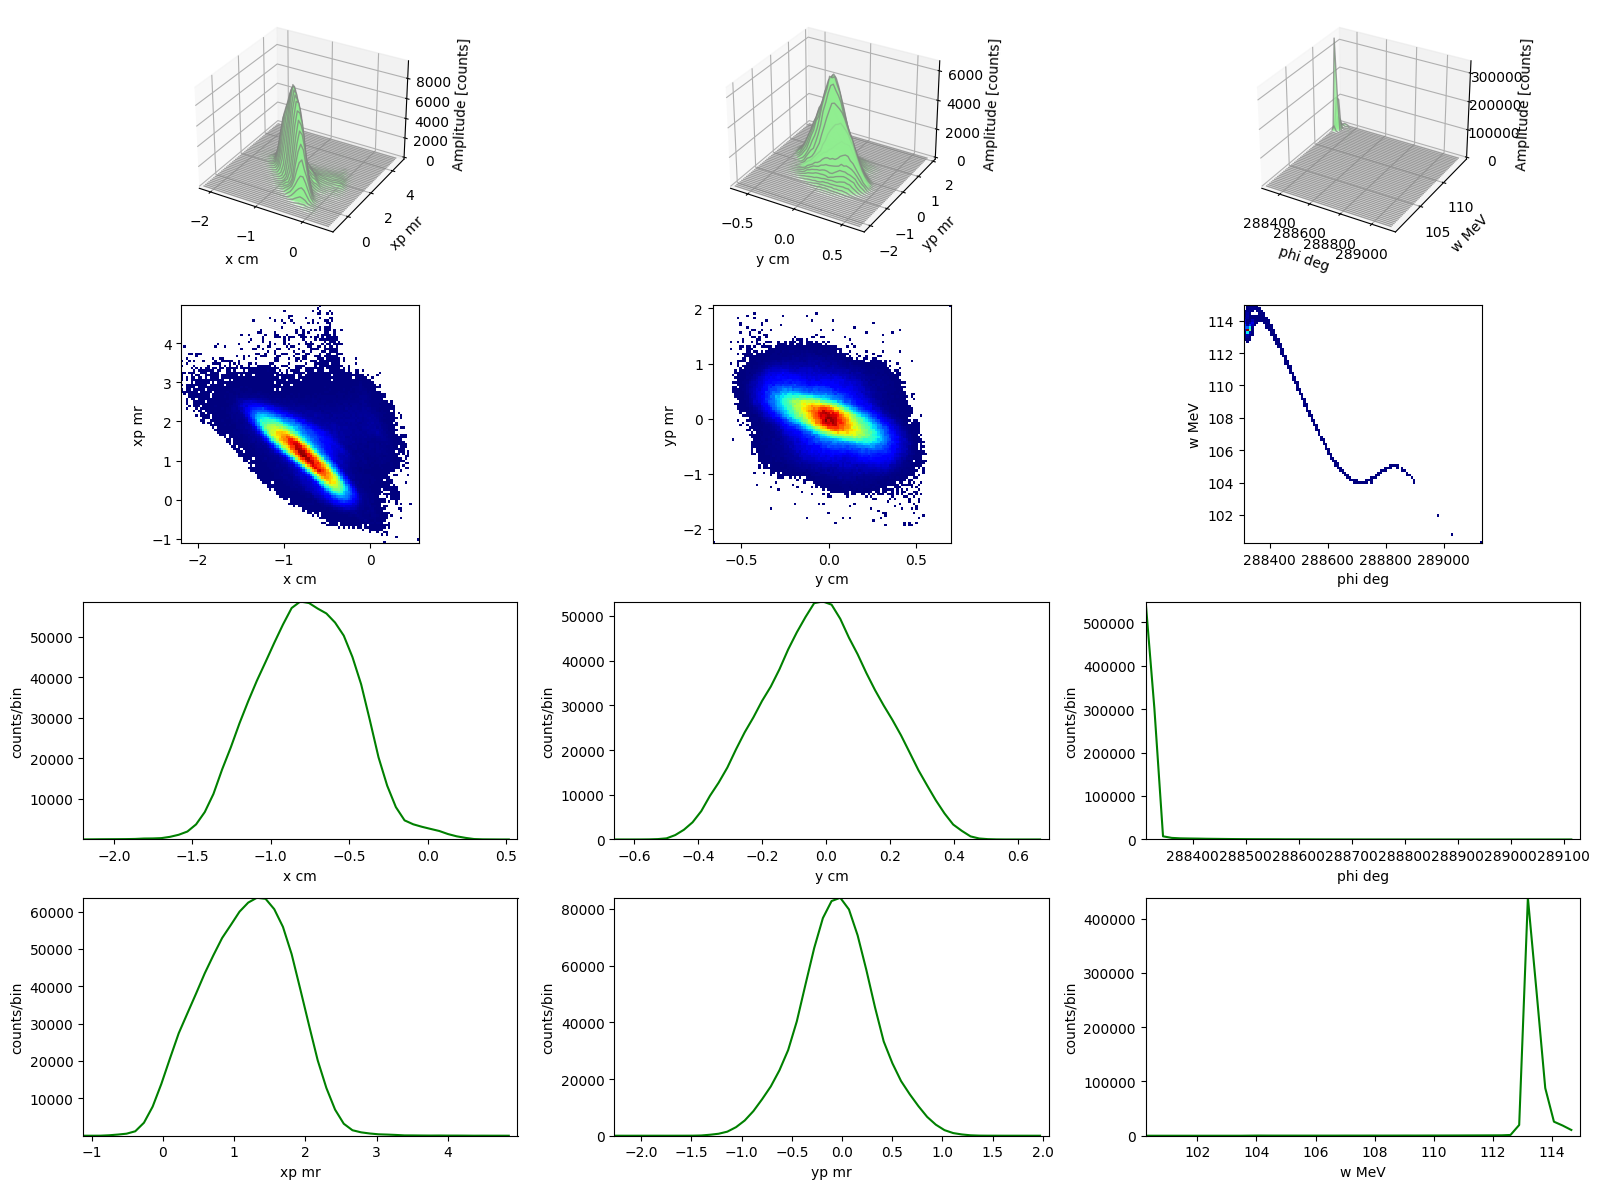

In [10]:
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_STOP)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)
plot.iso_phase_space('phiw', beam, mask, 3 )
plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)
plot.hist2d_phase_space('phiw', beam, mask, 6)
plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')
plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-')
plot.show()


 3 x  3 BeamPlot object created


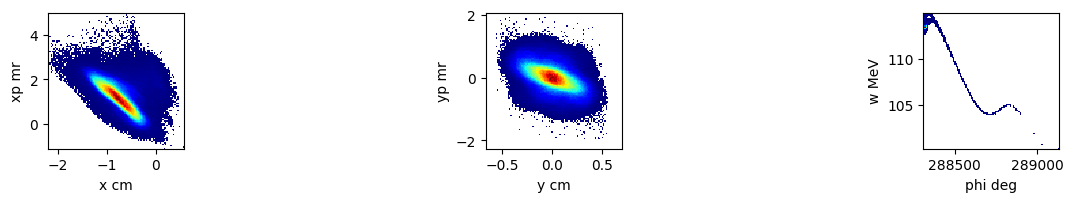

In [11]:
plot1 = hps.BeamPlot(nrow=3, ncol=3, hsize=16, vsize=6)
plot1.title(SIM_STOP)
plot1.hist2d_phase_space('xxp', beam, mask, 1)
plot1.hist2d_phase_space('yyp', beam, mask, 2)
plot1.hist2d_phase_space('phiw', beam, mask, 3)

In [12]:
arr_phi = (beam.get_coor("phi", mask)-288290)%360
arr_w = beam.get_coor("w", mask)
arr_x = beam.get_coor("x", mask)
arr_xp = beam.get_coor("xp", mask)
arr_y = beam.get_coor("y", mask)
arr_yp = beam.get_coor("yp", mask)

/home/bizon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  This is separate from the ipykernel package so we can avoid doing imports until


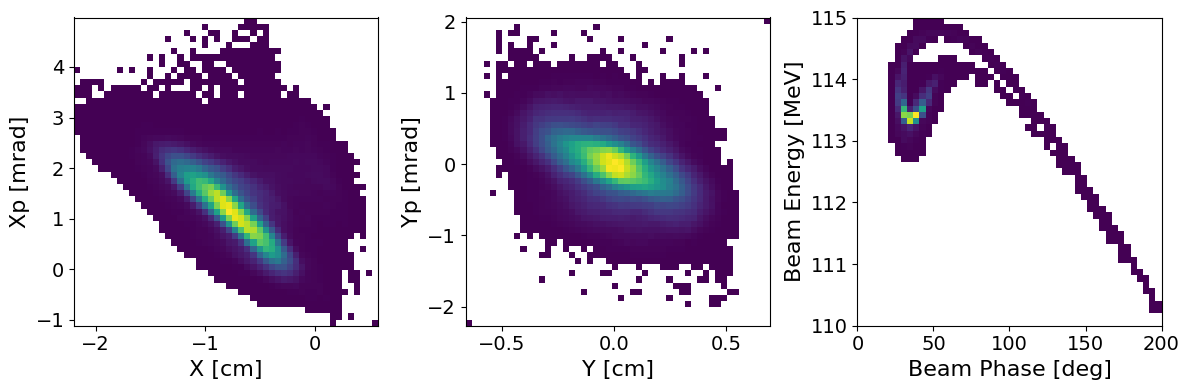

In [13]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
my_cmap = plt.cm.jet
my_cmap.set_under('w',0.1)
_ = axes[0].hist2d(arr_x, arr_xp, bins =[50,50] , cmin=1)
axes[0].set_ylabel("Xp [mrad]", fontsize=16)
axes[0].set_xlabel("X [cm]", fontsize=16)
axes[0].tick_params(axis="both", labelsize=14)


_ = axes[1].hist2d(arr_y, arr_yp, bins =[50,50] , cmin=1)
axes[1].set_ylabel("Yp [mrad]", fontsize=16)
axes[1].set_xlabel("Y [cm]", fontsize=16)
axes[1].tick_params(axis="both", labelsize=14)

_ = axes[2].hist2d(arr_phi, arr_w, bins =[np.linspace(0,200, 50), np.linspace(110,115,50)] , cmin=1)
axes[2].set_xlabel("Beam Phase [deg]", fontsize=16)
axes[2].set_ylabel("Beam Energy [MeV]", fontsize=16)
axes[2].tick_params(axis="both", labelsize=14)
fig.tight_layout()
fig.savefig("hist2d_05DT.pdf")

In [14]:
print("length of mask", len(mask))
print("mask ==True", np.sum(mask))

length of mask 878096
mask ==True 406746663366
